# 0.Imports

In [1]:
import sys
import os
# Adiciona o diretório raiz ao path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "..")))

from src.ruleclassifier import ClassificadorBaseadoEmRegras
from src.utils import plot_confusion_matrix
import pandas as pd
import numpy as np

In [4]:
os.path.abspath(os.path.join(os.getcwd(), "..", ".."))

'/home/esdras-daniel/Documentos/Python/PGM-DataAnalysis/legacy'

# 1. Data Loading

In [3]:
df = pd.read_csv('/home/esdras-daniel/Documentos/Python/PGM-DataAnalysis/data/processed/pgm-dataset-v6-clean.csv')

In [4]:
df.head()

,tipoAviso,orgaoJulgador,assuntos,documentos,classeProcesso,novoSetorDestino,teorTexto_clean
0,Intimação,5ª VEFT de Natal,5952,Despacho;Petição;Intimação;Diligência;Penhora;...,1116,AF,a contato processo exequente munic...
1,Intimação,4ª VEFT de Natal,10536;5952,Certidão Trânsito em Julgado;Sentença;Petição ...,1116,AF,a processo acao execucao fi...
2,Intimação,4ª VEFT de Natal,5951,Decisão;Diligência;Mandado;Despacho;Certidão;D...,1116,AF,o direito central avaliacao arrematacao ...
3,Intimação,6ª VEFT de Natal,10534;5952,Documento de Comprovação;Petição;Intimação;Dil...,1116,AF,a contato processo exequente munic...
4,Intimação,2ª VEFT de Natal,5951,Petição;Despacho;Petição;Decisão;Petição;Despa...,1116,AF,tributaria processo execucao fiscal ...


In [6]:
df['teorTexto_clean'] = df['teorTexto_clean'].fillna('')

# 2. Rule Classifier

In [7]:
rule_clf = ClassificadorBaseadoEmRegras()

## 2.1 - Registrando Regras

In [8]:
# REGRA 1:  SE tipoAviso = I E orgaoJulgador = 4ª VEFT N  E (teorTexto_clean CONTÉM "fazenda" OU teorTexto_clean CONTÉM "publica") ENTÃO setorDestino = AF
def rule1(row):
    return(row['tipoAviso'] == 'Intimação' and
           'VEFT' in row['orgaoJulgador'] and
           ('fazenda' in row['teorTexto_clean'] or 'publica' in row['teorTexto_clean']))

# REGRA 2: SE classeProcesso = 1116 E assuntos CONTÉM "10536" E "5952" ENTÃO setorDestino = AF
def rule2(row):
    return (row['classeProcesso'] == 1116 and
           '10536' in row['assuntos'] and '5952' in row['assuntos'] )

# REGRA 3: SE orgaoJulgador CONTÉM "JFP" (Juizado da Fazenda Pública) ENTÃO setorDestino = DCC
def rule3(row):
    return 'JFP' in row['orgaoJulgador']

# Kézia
# REGRA 4: SE orgaoJulgador = VEFT E classeProcesso = 1116 E (teorTexto_clean CONTÉM alvará E teorTexto_clean CONTÉM expe {de expedição, expedir, etc...}) ENTÃO setorDestino = NDD - AF
def rule4(row):
    return ('VEFT' in row['orgaoJulgador'] and
            row['classeProcesso'] == 1116 and
            ('alvara' in row['teorTexto_clean'] or 'expe' in row['teorTexto_clean']))

# REGRA 5: SE orgaoJulgador = VEFT E classeProcesso = 1116 E (teorTexto_clean CONTÉM alvará E teorTexto_clean CONTÉM expe {de expedição, expedir, etc...} E teorTexto_clean CONTÉM art 40) ENTÃO setorDestino = AF
def rule5(row):
    return ('VEFT' in row['orgaoJulgador'] and
            row['classeProcesso'] == 1116 and
            #('alvara' in row['teorTexto_clean'] or 'expe' in row['teorTexto_clean']) and
            'art 40' in row['teorTexto_clean'])


rule_clf.adicionar_regra('Regra1', rule1, prioridade=10, consequente='AF')
rule_clf.adicionar_regra('Regra2', rule2, prioridade=8, consequente='AF')
rule_clf.adicionar_regra('Regra3', rule3, 'DCC')
rule_clf.adicionar_regra('Regra4', rule4, 'NDD - AF')
rule_clf.adicionar_regra('Regra5', rule5, 'AF')

AttributeError: 'ClassificadorBaseadoEmRegras' object has no attribute 'add_rule'

# 3. Classificando os dados

In [7]:
accuracy, y_pred = rule_clf.evaluate(df, df['novoSetorDestino'])

print(f'Acurácia: {accuracy*100:.2f}%')

Acurácia: 32.02%


# 4. Avaliando

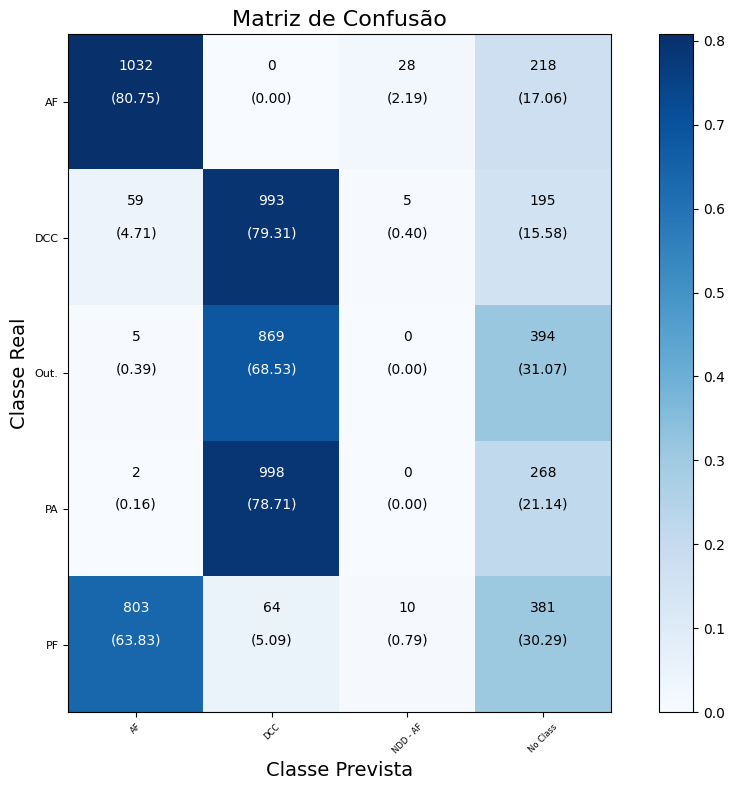

In [8]:
class_names = np.unique(df['novoSetorDestino'])

plot_confusion_matrix(y_true=df['novoSetorDestino'], y_pred=y_pred, class_names=class_names)

In [9]:
rule_clf.get_rule_counts()

{'rule_1': 1491, 'rule_2': 410, 'rule_3': 2924, 'rule_4': 43, 'rule_5': 0}

In [10]:
rule_clf.rule_correct_counts

{'rule_1': 768, 'rule_2': 264, 'rule_3': 993, 'rule_4': 0, 'rule_5': 0}

In [11]:
rule_clf.get_rule_confidence()

{'rule_1': 0.5150905432595574,
 'rule_2': 0.6439024390243903,
 'rule_3': 0.3396032831737346,
 'rule_4': 0.0,
 'rule_5': 0.0}

In [12]:
rule_clf.rule_correct_counts

{'rule_1': 768, 'rule_2': 264, 'rule_3': 993, 'rule_4': 0, 'rule_5': 0}